# Capstone Presentation

## Find a Dataset

I will be investigating a Kaggle dataset gathered from a [Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment). It was compiled by 2 Columbia Business School professors for their paper "Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment", which they wrote in an effort to understand what influences "love at first sight".

Data was gathered from participants in experimental speed dating events 2002-2004. During the events, the attendees would have a 4-minute "first date" with every other participant of the opposite sex. At the end of their 4 minutes, participants were asked to rate their date on 6 attributes: 

- Attractiveness
- Sincerity
- Intelligence
- Fun
- Ambition
- Shared Interests

They were also asked if they would like to see their date again.

The dataset also includes questionnaire data gathered from participants at different points in the process (i.e. demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information). 

## Set a Supervised Learning Goal

My goal is to be able to take this questionnaire data (namely my preferences, partner's preferences, what I think the opposite sex's preferences are, how I think I measure up to opposite sex's preferences).

## Explore Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

raw_data = pd.read_csv('./data/speed_dating.csv', encoding="ISO-8859-1")
print(raw_data.shape[0], 'Rows')
print(raw_data.shape[1], 'Columns')
raw_data.head()

8378 Rows
195 Columns


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [2]:
def get_col_descriptions(df):
    cols_many_nans = []
    for idx, col in enumerate(df.columns):
        num_uniq = len(df[col].unique())
        formatted_msg = '{}. {} – {} uniq vals'.format(idx + 1, col, num_uniq)
        
        if df[col].isnull().sum() > 0:
            num_nans = df[col].isnull().sum()
            percent_nans = round(num_nans / df.shape[0] * 100, 2)
            print(formatted_msg + '; {} NaNs ({}%)'.format(num_nans, percent_nans))
            if percent_nans > 50:
                cols_many_nans.append(col)
        else:
            print(formatted_msg)
    print('\n{} columns with 50+% NaNs: {}'.format(len(cols_many_nans), cols_many_nans))
    return cols_many_nans

cols_many_nans = get_col_descriptions(raw_data)

1. iid – 551 uniq vals
2. id – 23 uniq vals; 1 NaNs (0.01%)
3. gender – 2 uniq vals
4. idg – 44 uniq vals
5. condtn – 2 uniq vals
6. wave – 21 uniq vals
7. round – 15 uniq vals
8. position – 22 uniq vals
9. positin1 – 23 uniq vals; 1846 NaNs (22.03%)
10. order – 22 uniq vals
11. partner – 22 uniq vals
12. pid – 552 uniq vals; 10 NaNs (0.12%)
13. match – 2 uniq vals
14. int_corr – 156 uniq vals; 158 NaNs (1.89%)
15. samerace – 2 uniq vals
16. age_o – 25 uniq vals; 104 NaNs (1.24%)
17. race_o – 6 uniq vals; 73 NaNs (0.87%)
18. pf_o_att – 95 uniq vals; 89 NaNs (1.06%)
19. pf_o_sin – 79 uniq vals; 89 NaNs (1.06%)
20. pf_o_int – 66 uniq vals; 89 NaNs (1.06%)
21. pf_o_fun – 72 uniq vals; 98 NaNs (1.17%)
22. pf_o_amb – 83 uniq vals; 107 NaNs (1.28%)
23. pf_o_sha – 86 uniq vals; 129 NaNs (1.54%)
24. dec_o – 2 uniq vals
25. attr_o – 19 uniq vals; 212 NaNs (2.53%)
26. sinc_o – 15 uniq vals; 287 NaNs (3.43%)
27. intel_o – 18 uniq vals; 306 NaNs (3.65%)
28. fun_o – 18 uniq vals; 360 NaNs (4.3%)
29

## Clean Data

In [3]:
# Normalize columns of interest on appropriate scale (e.g. 'rate on a scale of 1 to x')
df = raw_data.copy()

# TODO: CONSOLIDATING ROWS FOR SAME DATES
my_prefs = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
partners_prefs = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']
guess_opp_sex_prefs = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
guess_my_rating = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
ratings_for_me = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']
ratings_for_partner = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']

diff_my_prefs_and_ratings = []
diff_partners_prefs_and_ratings = []

for idx in range(len(my_prefs)):
    diff_col_name = 'diff_my_' + ratings_for_partner[idx]
    diff_my_prefs_and_ratings.append(diff_col_name)
    df[diff_col_name] = df[my_prefs[idx]] - df[ratings_for_partner[idx]]

for idx in range(len(partners_prefs)):
    diff_col_name = 'diff_partners_' + ratings_for_me[idx]
    diff_partners_prefs_and_ratings.append(diff_col_name)
    df[diff_col_name] = df[partners_prefs[idx]] - df[ratings_for_me[idx]]

df[my_prefs] = raw_data[my_prefs].apply(lambda x: round(x / 100, 2))
df[partners_prefs] = raw_data[partners_prefs].apply(lambda x: round(x / 100, 2))
df[guess_opp_sex_prefs] = raw_data[guess_opp_sex_prefs].apply(lambda x: round(x / 100, 2))
df[guess_my_rating] = raw_data[guess_my_rating].apply(lambda x: round(x / 10, 2))
df[ratings_for_me] = raw_data[ratings_for_me].apply(lambda x: round(x / 10, 2))
df[ratings_for_partner] = raw_data[ratings_for_partner].apply(lambda x: round(x / 10, 2))

df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
0,1,1.0,0,1,1,1,10,7,NaN,4,...,13.0,8.0,9.0,10.0,29.0,12.0,12.0,12.0,-8.0,-1.0
1,1,1.0,0,1,1,1,10,7,NaN,3,...,13.0,7.0,10.0,9.0,53.0,-8.0,-10.0,33.0,-7.0,-5.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,11.0,7.0,10.0,8.0,9.0,8.0,9.0,8.0,4.0,2.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,12.0,8.0,9.0,7.0,23.0,-3.0,6.0,32.0,-4.0,-3.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,13.0,8.0,9.0,9.0,22.0,3.0,11.0,4.0,1.0,13.0


In [4]:
# Drop cols with more than 50% NaNs
df = df.drop(labels=cols_many_nans, axis=1)

# Drop id cols
id_cols = ['iid', 'id', 'idg', 'pid']
df = df.drop(labels=id_cols, axis=1)

df.head()

,gender,condtn,wave,round,position,positin1,order,partner,match,int_corr,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
0,0,1,1,10,7,NaN,4,1,0,0.14,...,13.0,8.0,9.0,10.0,29.0,12.0,12.0,12.0,-8.0,-1.0
1,0,1,1,10,7,NaN,3,2,0,0.54,...,13.0,7.0,10.0,9.0,53.0,-8.0,-10.0,33.0,-7.0,-5.0
2,0,1,1,10,7,NaN,10,3,1,0.16,...,11.0,7.0,10.0,8.0,9.0,8.0,9.0,8.0,4.0,2.0
3,0,1,1,10,7,NaN,5,4,1,0.61,...,12.0,8.0,9.0,7.0,23.0,-3.0,6.0,32.0,-4.0,-3.0
4,0,1,1,10,7,NaN,7,5,1,0.21,...,13.0,8.0,9.0,9.0,22.0,3.0,11.0,4.0,1.0,13.0


In [5]:
cols_with_nans = list(df.columns[df.isna().any()])
cols_without_nans = list(set(df.columns) - set(cols_with_nans))
print('Columns with NaNs:\n', ', '.join(cols_with_nans))
print('\nColumns without NaNs:\n', ', '.join(cols_without_nans))

Columns with NaNs:
 positin1, int_corr, age_o, race_o, pf_o_att, pf_o_sin, pf_o_int, pf_o_fun, pf_o_amb, pf_o_sha, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o, like_o, prob_o, met_o, age, field, field_cd, undergra, race, imprace, imprelig, from, zipcode, income, goal, date, go_out, career, career_c, sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga, exphappy, attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1, attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1, shar4_1, attr2_1, sinc2_1, intel2_1, fun2_1, amb2_1, shar2_1, attr3_1, sinc3_1, fun3_1, intel3_1, amb3_1, attr5_1, sinc5_1, intel5_1, fun5_1, amb5_1, attr, sinc, intel, fun, amb, shar, like, prob, met, match_es, satis_2, length, numdat_2, attr1_2, sinc1_2, intel1_2, fun1_2, amb1_2, shar1_2, attr4_2, sinc4_2, intel4_2, fun4_2, amb4_2, shar4_2, attr2_2, sinc2_2, intel2_2, fun2_2, amb2_2, shar2_2, attr3_2, sinc3_2, intel3_2, fun3_2, amb3_2, attr5_2, 

In [6]:
cols_of_interest = my_prefs + partners_prefs + guess_opp_sex_prefs + guess_my_rating + ratings_for_me + ratings_for_partner + diff_my_prefs_and_ratings + diff_partners_prefs_and_ratings

# For 1st stage of modeling, look only at columns of interest and the target ('match')
df = df[cols_of_interest + ['match']]
df.head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,match
0,0.15,0.2,0.2,0.15,0.15,0.15,0.35,0.20,0.20,0.20,...,8.0,9.0,10.0,29.0,12.0,12.0,12.0,-8.0,-1.0,0
1,0.15,0.2,0.2,0.15,0.15,0.15,0.60,0.00,0.00,0.40,...,7.0,10.0,9.0,53.0,-8.0,-10.0,33.0,-7.0,-5.0,0
2,0.15,0.2,0.2,0.15,0.15,0.15,0.19,0.18,0.19,0.18,...,7.0,10.0,8.0,9.0,8.0,9.0,8.0,4.0,2.0,1
3,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.05,0.15,0.40,...,8.0,9.0,7.0,23.0,-3.0,6.0,32.0,-4.0,-3.0,1
4,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.10,0.20,0.10,...,8.0,9.0,9.0,22.0,3.0,11.0,4.0,1.0,13.0,1


In [7]:
# Drop rows with null values
def drop_nulls(df):
    old_num = df.shape[0]
    df = df.dropna(axis=0)
    
    num_dropped = old_num - df.shape[0]
    perc_dropped = round(num_dropped / old_num * 100, 2)
    print('{} rows({}%) dropped'.format(num_dropped, perc_dropped))
    
    perc_left = round(df.shape[0] / old_num * 100, 2)
    print('{} rows ({}%) left'.format(df.shape[0], perc_left))
    return df

df = drop_nulls(df)
df.head()

# Instead of dropping nulls, could one corroborate with the person's partner's row?

2556 rows(30.51%) dropped
5822 rows (69.49%) left


,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,match
0,0.15,0.2,0.2,0.15,0.15,0.15,0.35,0.20,0.20,0.20,...,8.0,9.0,10.0,29.0,12.0,12.0,12.0,-8.0,-1.0,0
1,0.15,0.2,0.2,0.15,0.15,0.15,0.60,0.00,0.00,0.40,...,7.0,10.0,9.0,53.0,-8.0,-10.0,33.0,-7.0,-5.0,0
2,0.15,0.2,0.2,0.15,0.15,0.15,0.19,0.18,0.19,0.18,...,7.0,10.0,8.0,9.0,8.0,9.0,8.0,4.0,2.0,1
3,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.05,0.15,0.40,...,8.0,9.0,7.0,23.0,-3.0,6.0,32.0,-4.0,-3.0,1
4,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.10,0.20,0.10,...,8.0,9.0,9.0,22.0,3.0,11.0,4.0,1.0,13.0,1


In [8]:
# Drop rows with incorrect math
df['my_prefs_total'] = df[my_prefs].sum(axis='columns')
df['partners_prefs_total'] = df[partners_prefs].sum(axis='columns')
df['guess_opp_sex_prefs_total'] = df[guess_opp_sex_prefs].sum(axis='columns')

total_col_names = ['my_prefs_total', 'partners_prefs_total', 'guess_opp_sex_prefs_total']
for col in total_col_names:
    print(col, '\n* uniq vals –', ', '.join(map(lambda x: str(round(x, 2)), list(df[col].unique()))))

    # Drop row if math is off by more than 10% (0.1)
    old_num = df.shape[0]
    df = df[df[col] <= 1.1]
    df = df[df[col] >= 0.9]
    num_dropped = old_num - df.shape[0]
    perc_dropped = round(num_dropped / old_num * 100, 2)
    print('* {} rows dropped ({}%) \n* {} rows left\n'.format(num_dropped, perc_dropped, df.shape[0]))

df = df.drop(columns=total_col_names)
df.head()

my_prefs_total 
* uniq vals – 1.0, 1.0, 0.99, 0.99, 1.0, 1.2, 1.48, 0.9, 1.01, 0.9, 1.02, 0.98, 0.98, 1.01, 1.01, 0.99, 1.1, 0.95
* 58 rows dropped (1.0%) 
* 5764 rows left

partners_prefs_total 
* uniq vals – 1.0, 0.99, 1.0, 0.99, 1.2, 1.0, 1.48, 0.9, 1.01, 0.9, 1.02, 1.01, 1.01, 0.98, 0.98, 0.99, 0.95, 1.1
* 57 rows dropped (0.99%) 
* 5707 rows left

guess_opp_sex_prefs_total 
* uniq vals – 1.0, 1.0, 1.0, 0.95, 1.05, 1.01, 0.98, 1.02, 0.98, 0.99, 0.99, 1.01, 0.99, 1.1, 0.95, 1.1, 0.9, 0.9, 1.12
* 38 rows dropped (0.67%) 
* 5669 rows left



,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,match
0,0.15,0.2,0.2,0.15,0.15,0.15,0.35,0.20,0.20,0.20,...,8.0,9.0,10.0,29.0,12.0,12.0,12.0,-8.0,-1.0,0
1,0.15,0.2,0.2,0.15,0.15,0.15,0.60,0.00,0.00,0.40,...,7.0,10.0,9.0,53.0,-8.0,-10.0,33.0,-7.0,-5.0,0
2,0.15,0.2,0.2,0.15,0.15,0.15,0.19,0.18,0.19,0.18,...,7.0,10.0,8.0,9.0,8.0,9.0,8.0,4.0,2.0,1
3,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.05,0.15,0.40,...,8.0,9.0,7.0,23.0,-3.0,6.0,32.0,-4.0,-3.0,1
4,0.15,0.2,0.2,0.15,0.15,0.15,0.30,0.10,0.20,0.10,...,8.0,9.0,9.0,22.0,3.0,11.0,4.0,1.0,13.0,1


In [9]:
matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

num_matches = matches.shape[0]
num_non_matches = non_matches.shape[0]
perc_minority = round(num_matches / df.shape[0] * 100, 2)
perc_majority = round(num_non_matches / df.shape[0] * 100, 2)

print(('{} TOTAL: \n   {} matches ({}%)\n   {} non-matches ({}%)').format(df.shape[0], num_matches, perc_minority, num_non_matches, perc_majority))

5669 TOTAL: 
   987 matches (17.41%)
   4682 non-matches (82.59%)


## Data Visualization

In [10]:
df.columns

Index(['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1',
       'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'diff_my_attr', 'diff_my_sinc',
       'diff_my_intel', 'diff_my_fun', 'diff_my_amb', 'diff_my_shar',
       'diff_partners_attr_o', 'diff_partners_sinc_o', 'diff_partners_intel_o',
       'diff_partners_fun_o', 'diff_partners_amb_o', 'diff_partners_shar_o',
       'match'],
      dtype='object')

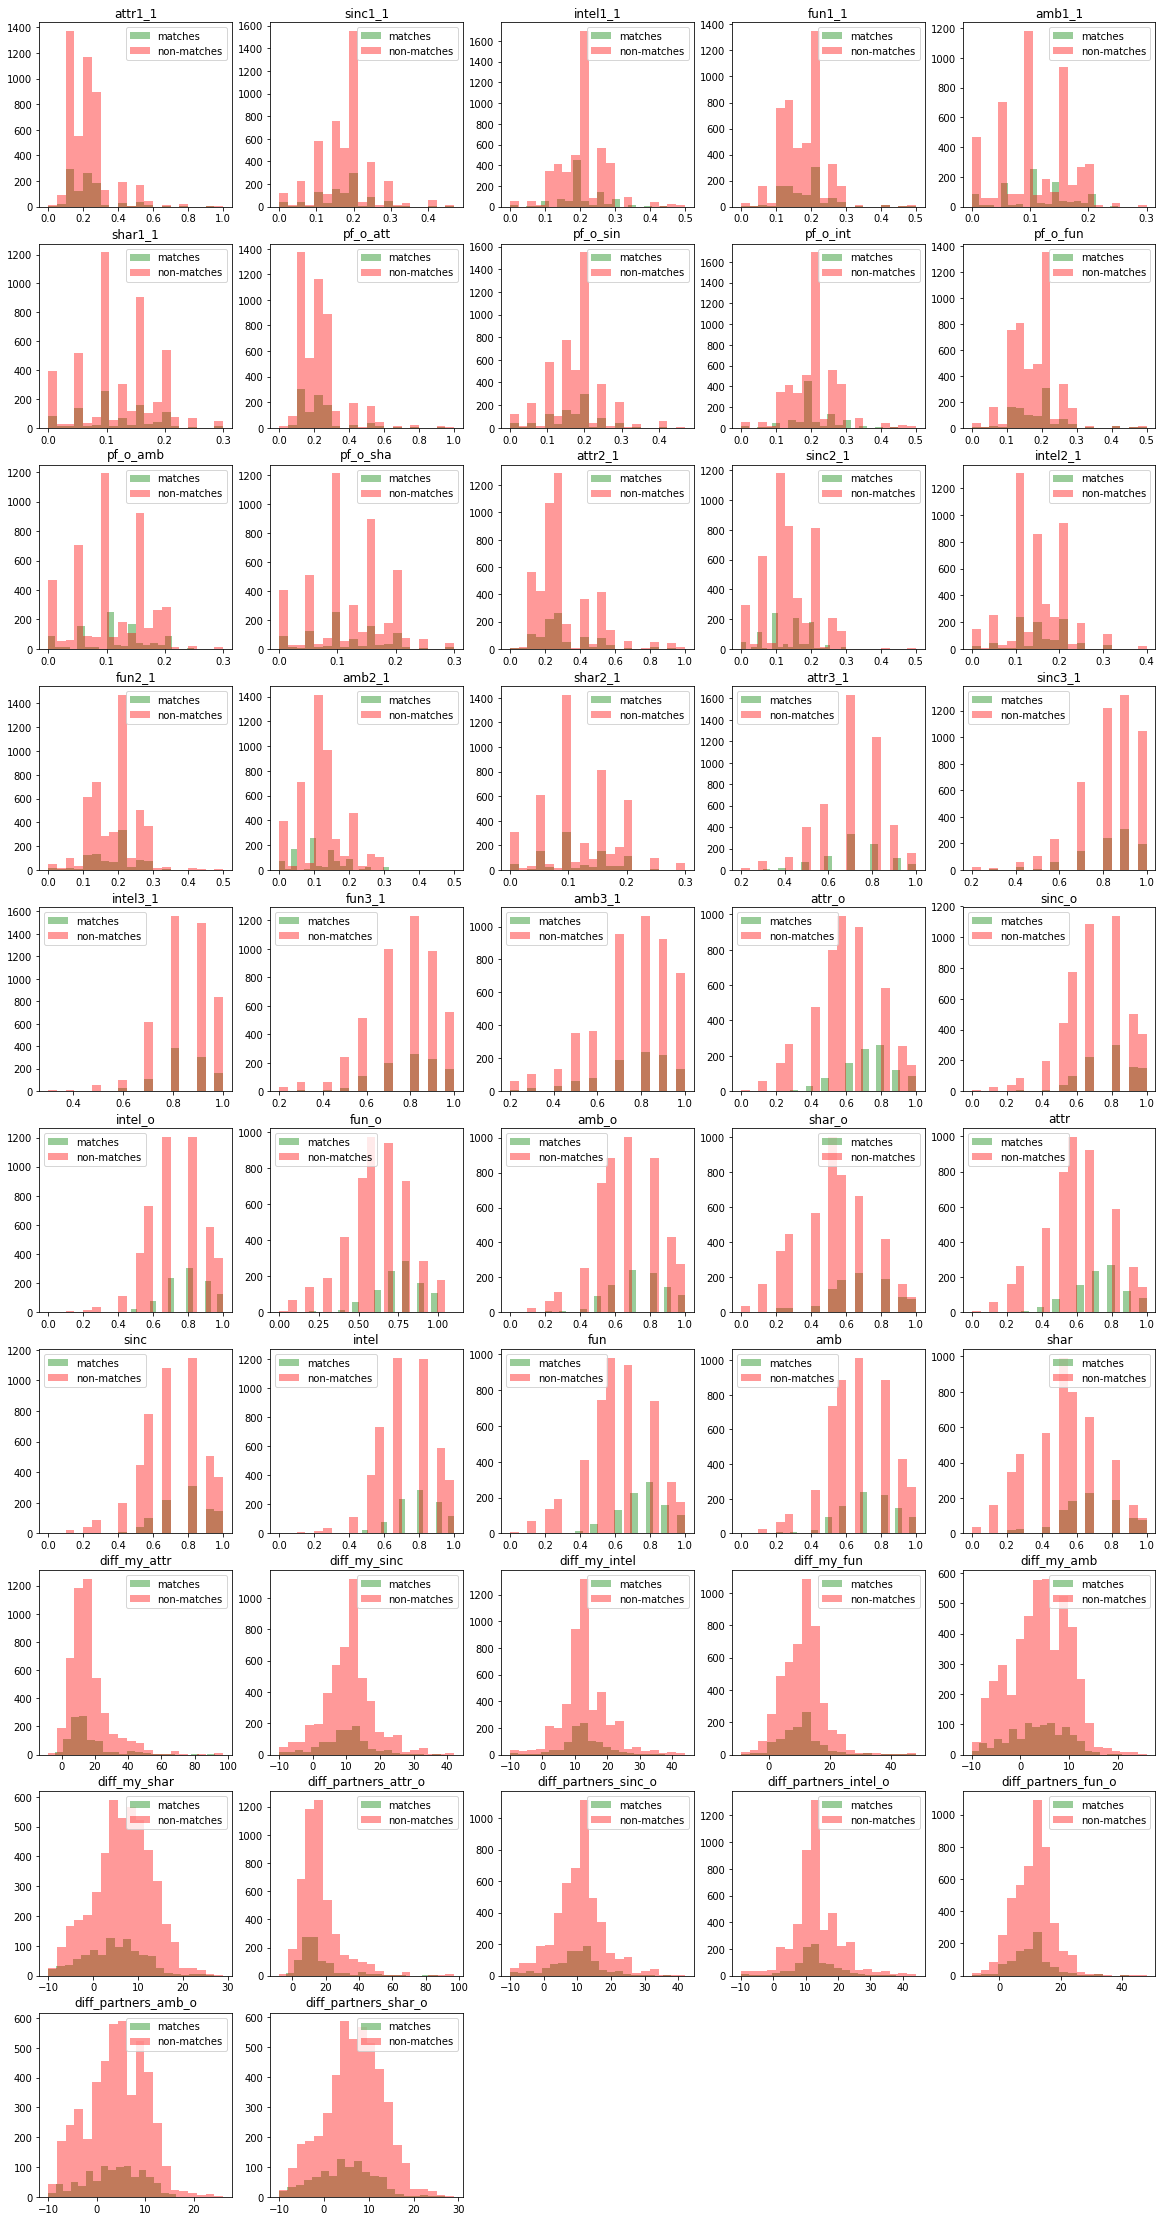

In [11]:
def show_distributions(df):
    plt.figure(figsize=(20, 40))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(10, 5, idx + 1)
        plt.hist(matches[col], alpha=0.4, bins= 20, color='green', label='matches')
        plt.hist(non_matches[col], alpha=0.4, bins= 20, color='red', label='non-matches')
        plt.legend()
        plt.title(col)

    plt.show()

show_distributions(df)

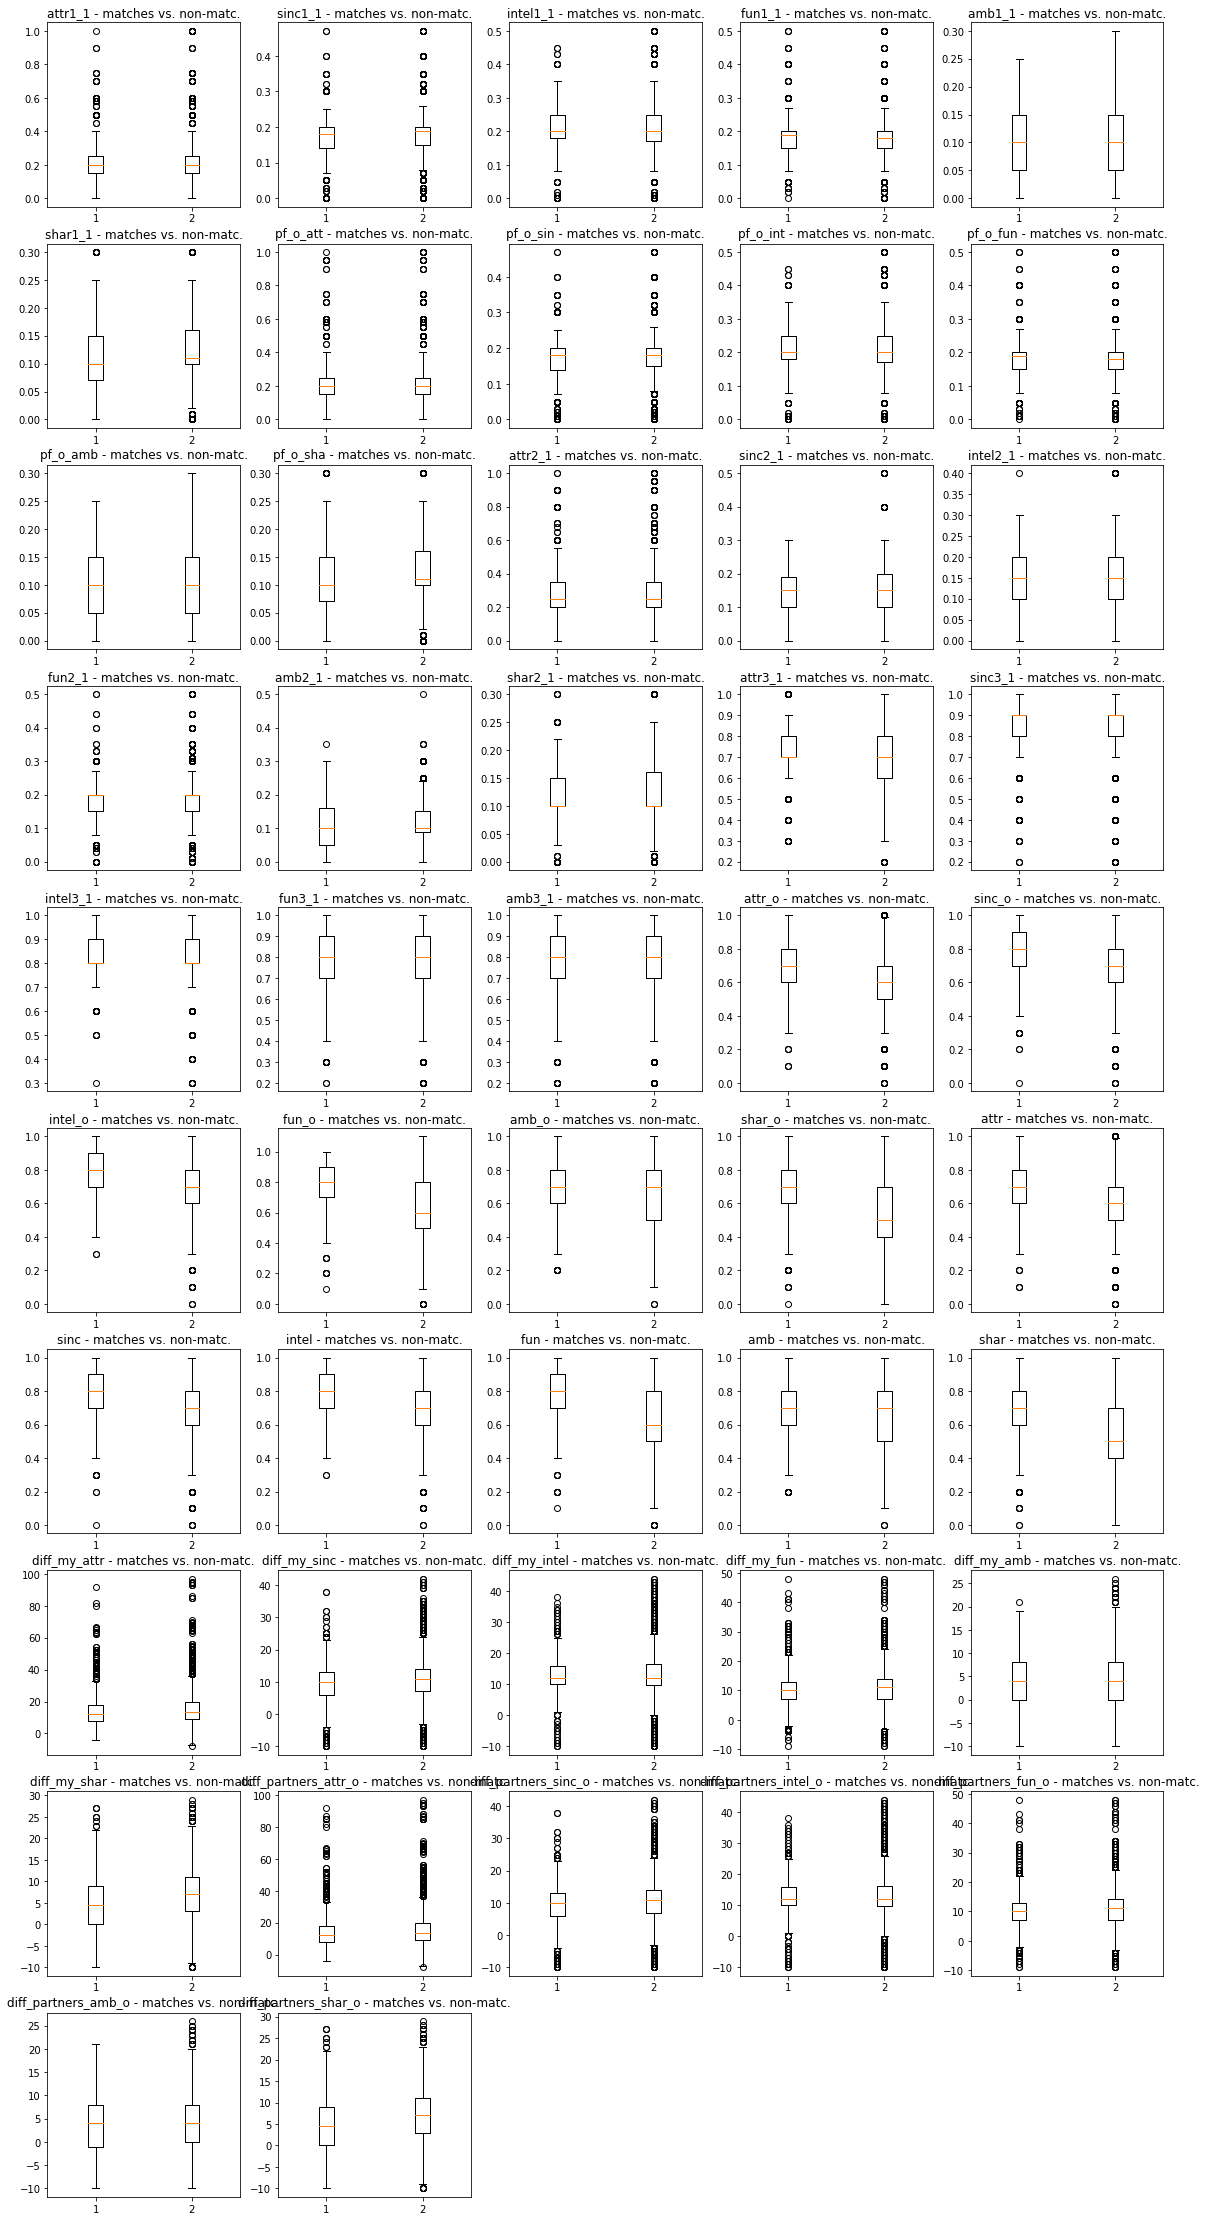

In [12]:
def show_boxplots(df):
    plt.figure(figsize=(20, 40))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(10, 5, idx + 1)
        plt.boxplot([matches[col], non_matches[col]])
        plt.title(col + ' - matches vs. non-matc.')

    plt.show()

show_boxplots(df)

## Over-Sampling to Counter Skewed Data

Because my dataset is so skewed in favor of non-matches, I will be over-sampling from my smaller group (matches) in order to train my models accurately.

In [13]:
X = df.loc[:, df.columns != 'match']
Y = df['match']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
new_df = pd.DataFrame(data = X_train_res, columns=cols_of_interest)
new_df['match'] = Y_train_res

new_df.head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,match
0,0.21,0.17,0.21,0.17,0.12,0.12,0.18,0.18,0.20,0.12,...,12.67,7.9,7.9,15.5,15.5,10.0,6.5,10.0,10.5,0
1,0.35,0.30,0.25,0.05,0.00,0.05,0.10,0.25,0.15,0.20,...,-1.00,-6.0,-1.0,6.0,17.0,6.0,12.0,6.0,13.0,0
2,0.15,0.15,0.20,0.15,0.15,0.20,0.15,0.10,0.30,0.10,...,7.00,7.0,16.0,8.0,0.0,22.0,2.0,-2.0,22.0,0
3,0.10,0.25,0.25,0.20,0.10,0.10,0.15,0.20,0.20,0.20,...,16.00,6.0,8.0,7.0,12.0,12.0,12.0,-3.0,12.0,0
4,0.10,0.30,0.30,0.10,0.10,0.10,0.22,0.22,0.15,0.15,...,5.00,3.0,4.0,14.0,13.0,7.0,5.0,-4.0,11.0,0


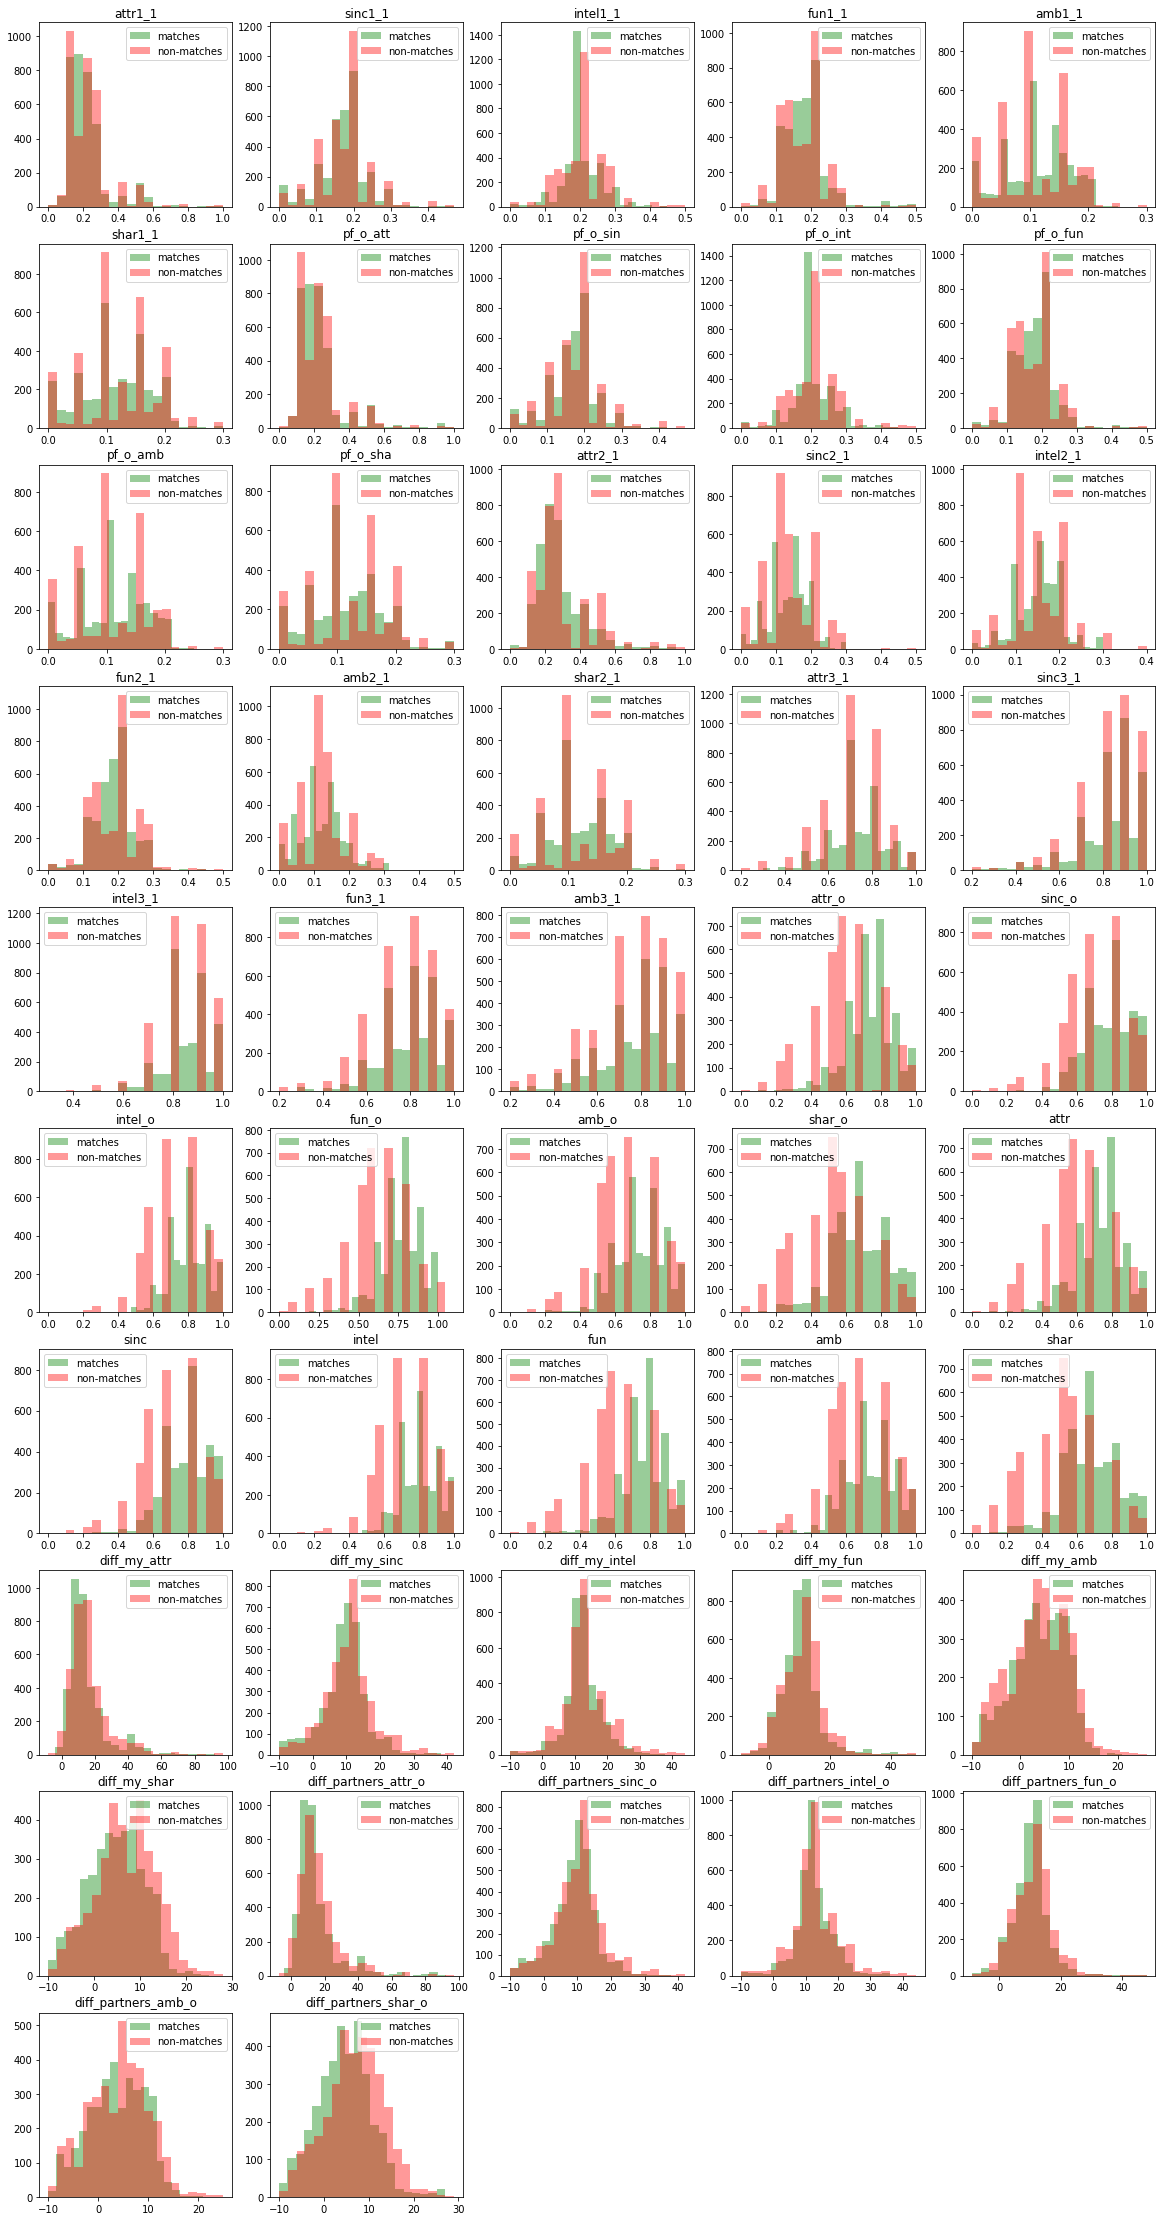

In [15]:
show_distributions(new_df)

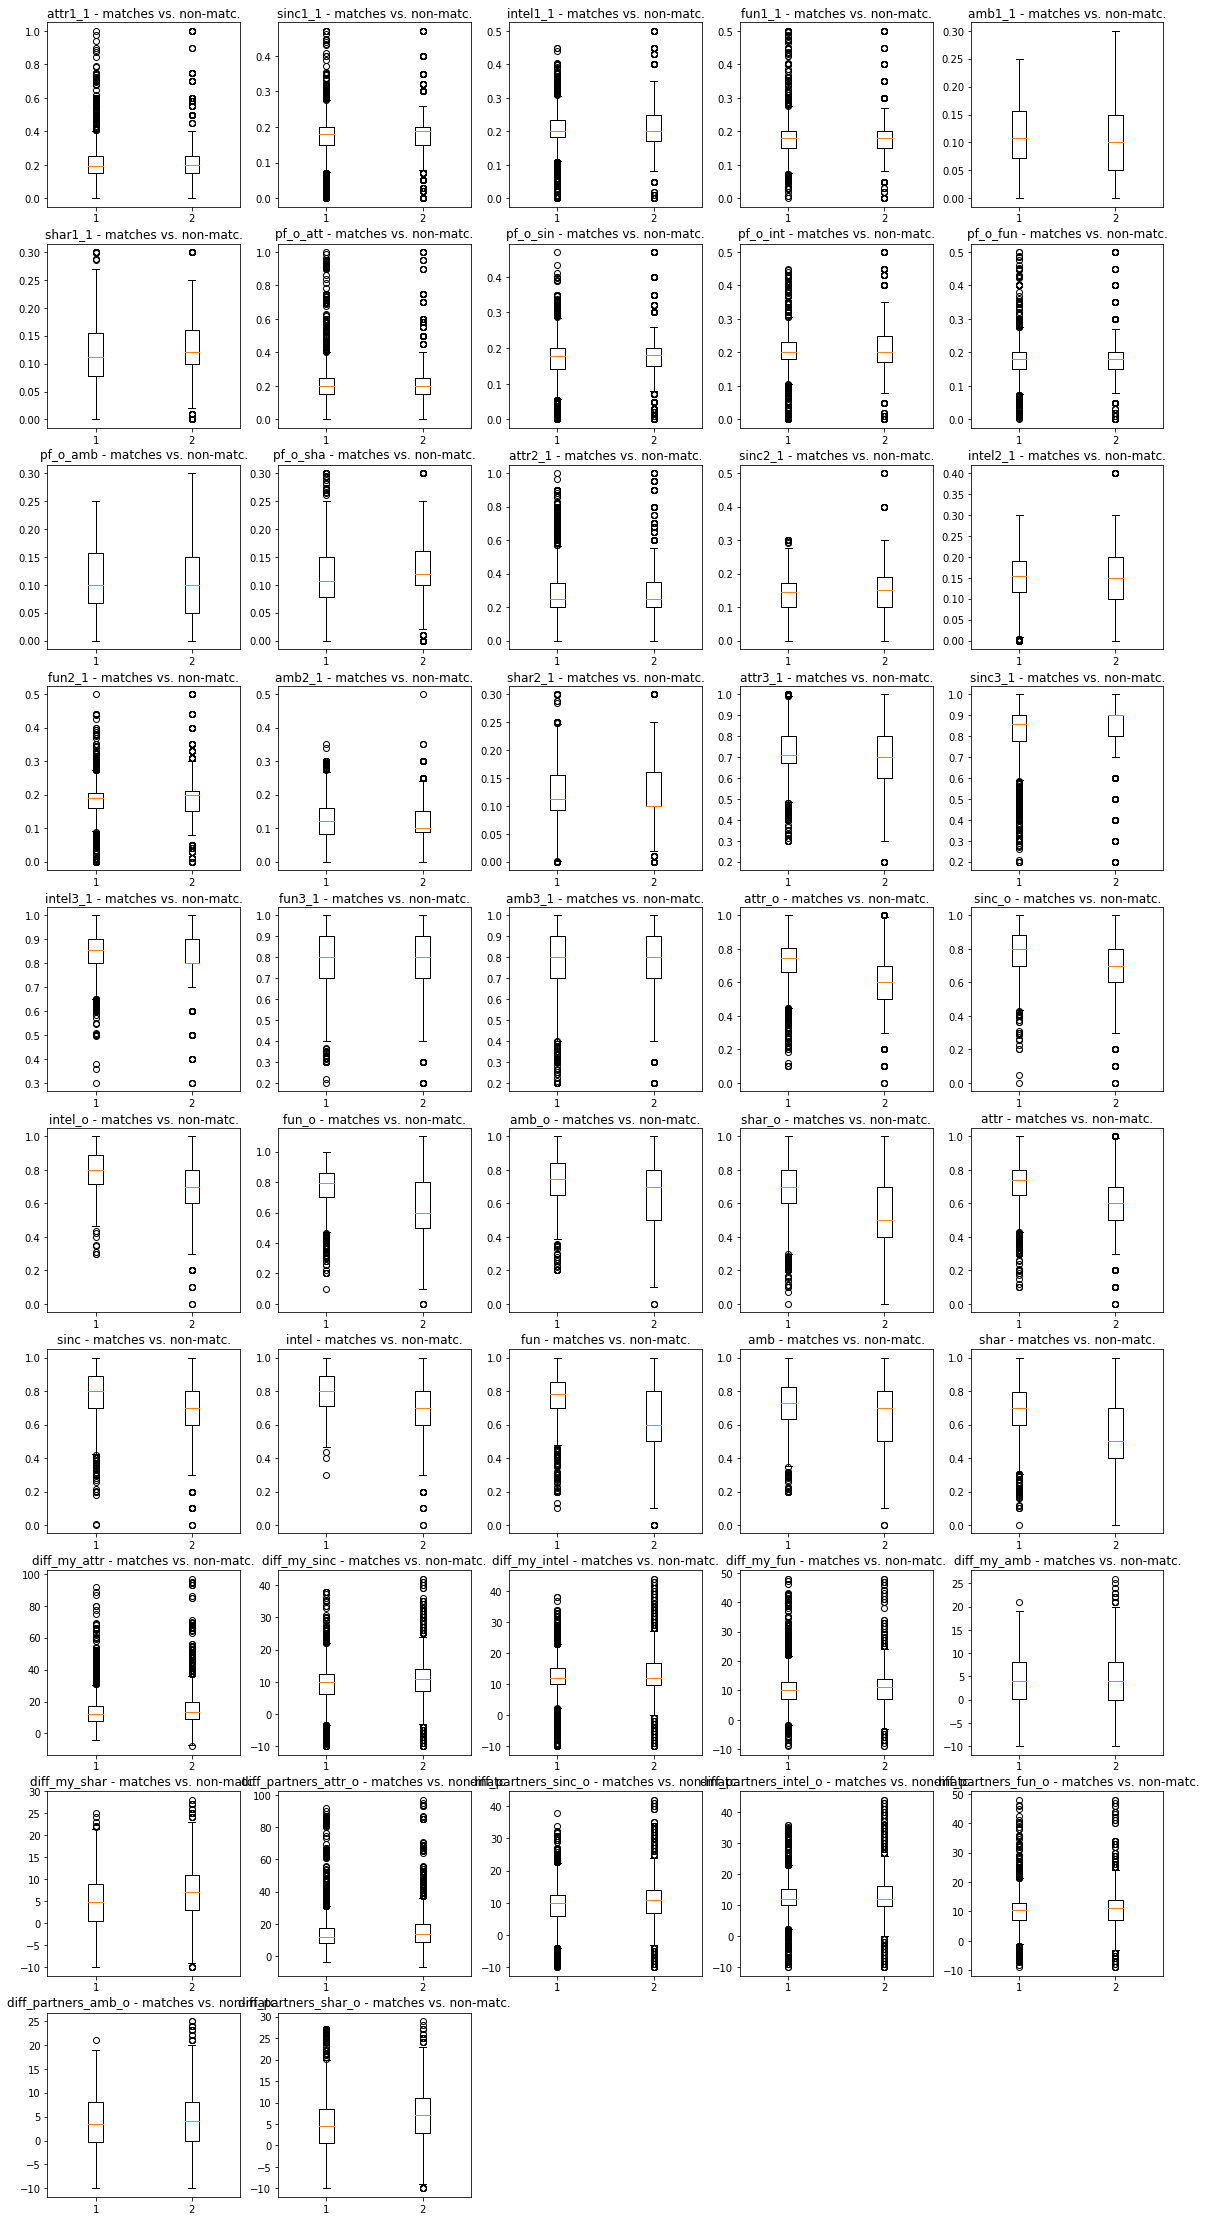

In [16]:
show_boxplots(new_df)

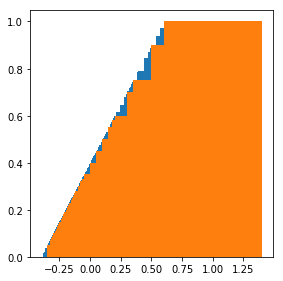

In [18]:
# TODO: barplot
# for people who match vs. not match – what are attributes that are highest in preferences
# in ratings, etc

# other visualizations

# difference between preferences and expectations among match vs. not match

matches = new_df[new_df['match'] == 1]
non_matches = new_df[new_df['match'] == 0]

plt.figure(figsize=(20,10))

for idx, feature in enumerate([my_prefs[0]]):
    plt.subplot(2, 4, idx + 1)
    plt.bar(matches[feature], height=matches[feature])
    plt.bar(non_matches[feature], height=non_matches[feature])
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(new_df.corr())
plt.show()

# Model for Target

Try several different approaches and work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. 

Think about explanatory versus predictive power and experiment with both.

In [ ]:
def fit_and_train(model):
    model_fit = model.fit(X_train_res, Y_train_res)
    model_score_train = model.score(X_train, Y_train)
    print('R² for train:', model_score_train)
    
    model_score_test = model.score(X_test, Y_test)
    print('R² for test:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print('\n', test_crosstab)
    
    tI_errors = test_crosstab.loc[0,1] / test_crosstab.loc['All','All'] * 100
    tII_errors = test_crosstab.loc[1,0] / test_crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))

    precision = test_crosstab.loc[1,1] / test_crosstab.loc['All', 1] * 100 
    recall = test_crosstab.loc[1,1] / test_crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))
    
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)

lasso = linear_model.LogisticRegression(penalty='l1', C=10) 
fit_and_train(lasso)

In [ ]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm)

In [ ]:
svm = SVC(kernel='linear', probability=True)
fit_and_train(svm)

In [ ]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc)

In [ ]:
bnb = BernoulliNB()
fit_and_train(bnb)

In [ ]:
# Make dummies for other categorical features and add to X and try models again

In [ ]:
# other_possible_cols = ['race', 'race_o', 'samerace', 'age', 'age_o', 'order', 'int_corr', 'expnum', 'dec_o']
# df = raw_data[['match'] + other_possible_cols]
# df = drop_nulls(df)

# df.head()

In [ ]:
# plt.figure(figsize=(10,5))
# sns.heatmap(df.corr())
# plt.show()

## Deliverables

Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

- A specified research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

You'll be presenting this slide deck live to a group as the culmination of your work in the last 2 supervised learning units. As a secondary matter, your slides and/or the Jupyter notebook you use or adapt them into should be worthy of inclusion as examples of your work product when applying to jobs.